# Brazil Sao Paulo sugarcane crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. The accompanying Gro web app display for [Brazil Sugarcane](https://app.gro-intelligence.com/displays/23713) provides an overview of the data series we will use. The crop model we will create is a very basic  model that uses crop-production-weighted NDVI to forecast  yield.

## Preliminary
Here we use a `CropModel` object as well as some feature transformation functions. We also save the entity ids for the `item` [sugarcane](https://app.gro-intelligence.com/dictionary/items/538), `metric` [processing yield](https://app.gro-intelligence.com/dictionary/metrics/6881050), and for the `region` [Sao Paulo](https://app.gro-intelligence.com/dictionary/regions/10408).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.

In [1]:
import sys
path_list = ['/Applications/PyCharm CE.app/Contents/helpers/pydev',
 '/Library/Frameworks/SQLite3.framework/Versions/C/Python/2.7',
 '/Library/Frameworks/GEOS.framework/Versions/3/Python/2.7/site-packages',
 '/Library/Frameworks/GDAL.framework/Versions/2.1/Python/2.7/site-packages',
 '/Library/Python/2.7/site-packages/pip-9.0.1-py2.7.egg',
 '/Library/Python/2.7/site-packages/pandas-0.21.1-py2.7-macosx-10.12-intel.egg',
 '/Applications/PyCharm CE.app/Contents/helpers/pydev',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload',
 '/Library/Python/2.7/site-packages',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python',
 '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/PyObjC',
 '/Library/Python/2.7/site-packages/IPython/extensions',
 '/Users/yizhao/Documents/gro/source_apps',
 '/Users/yizhao/Documents/gro']
for i in path_list:
    sys.path.append(i)
import os
import re
import shap
import pandas as pd
import itertools
from datetime import datetime


In [2]:
import os
from api.client.crop_model import CropModel

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
region_id = model.search_for_entity('regions', "Sao Paulo")
crop_id =  model.search_for_entity('items', "sugarcane, TRS")


##  Historical Sugar Processing yields
To get data series for the province level sugarcane yield for Sao Paulo, we set the entities (item, metric and region), and get the available data series.  The <em>source</em> for Sao Paulo sugarcane yields is [UNICA](https://app.gro-intelligence.com/dictionary/sources/47).

In [19]:
yield_entities = {}
yield_entities['item_id']  = crop_id
yield_entities['region_id'] = region_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "processing yield mass/mass")
yield_entities['source_id'] = 47 # unica
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

Added {u'end_date': u'2018-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
INFO:api.client.lib:Added {u'end_date': u'2018-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
Added {u'end_date': u'2019-05-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World'

There are 2 data series for {'item_id': 7539, 'source_id': 47, 'region_id': 10408, 'metric_id': 6881050}.
source_id 47: 2007-04-01T00:00:00.000Z to 2018-03-31T00:00:00.000Z
source_id 47: 2008-04-01T00:00:00.000Z to 2019-05-31T00:00:00.000Z


* As printed above, there are 2 available data series for the Sugar processing yield of Sao Paulo
* Next we retrive the data frame of those series and make sure to subset subset to the metric and region we need

In [20]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id'])]
yield_df.end_date = pandas.to_datetime(yield_df.end_date)
yield_df['DOY']  = yield_df.end_date.apply(lambda x: int(x.strftime('%j')))
yield_df['Year'] = yield_df.end_date.apply(lambda x: x.year)
yield_df.head()



/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value,DOY,Year
0,2008-04-15,23,866,1,7539,6881050,10408,2008-04-01T00:00:00.000Z,866,87.897155,106,2008
1,2008-04-30,23,866,1,7539,6881050,10408,2008-04-16T00:00:00.000Z,866,86.164431,121,2008
2,2008-05-15,23,866,1,7539,6881050,10408,2008-05-01T00:00:00.000Z,866,94.437959,136,2008
3,2008-05-31,23,866,1,7539,6881050,10408,2008-05-16T00:00:00.000Z,866,104.925017,152,2008
4,2008-06-15,23,866,1,7539,6881050,10408,2008-06-01T00:00:00.000Z,866,115.774950,167,2008


* The resulting data frame includes information on the start and end date of the periods corresponding to each processing yield observation, and ids representing the frequency, unit, unit scale, item, metric, and region of our Gro data series. 
* The Day of Year and Year columns are derived from the end_date column to help with feature transformation processing

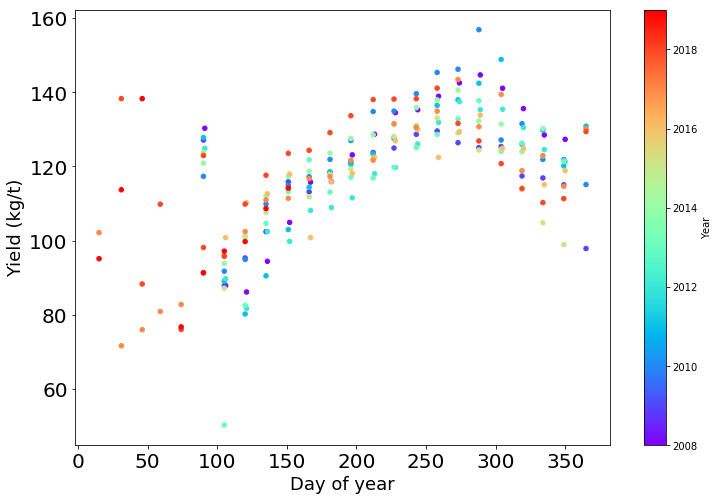

In [51]:
fig, axes = plt.subplots(1, 1)
yield_df[yield_df['value']<300].plot(x='DOY', y='value', kind='scatter',c='Year', cmap='rainbow',
                      ax=axes, figsize=(12,8), fontsize=20, legend=True)
plt.xlabel("Day of year", fontsize=18)
plt.ylabel("Yield (kg/t)", fontsize=18)
plt.show()

* As we can see in this figure above, the sugar processing yield follows a nice increasing pattern from the Day of year (DOY) 100 to about 270 and then goes back down 
* The processing yield between the DOY 350 and 100 appear to show no pattern, and there are only data points for recent years
* For the purpose of this analysis, we thus exclude the study period to between the DOY 100 and 350

In [49]:
df_within_range = yield_df[(yield_df['DOY'] > 100) & (yield_df['DOY'] < 350)]

## NDVI of Sao Paulo
The main signal we will use to model crop yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for yield (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [3]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3


entities['region_id'] = region_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-06-09T00:00:00.000Z', u'source_name': u'GIMMS MODIS NDVI', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Vegetation (NDVI)', u'partner_region_name': u'World', u'frequency_id': 3, u'source_id': 3, u'partner_region_id': 0, u'item_id': 321, u'metric_name': u'Vegetation Indices', u'start_date': u'2000-02-18T00:00:00.000Z', u'metric_id': 70029}


In [5]:
model._data_series_list


[{u'end_date': u'2019-06-09T00:00:00.000Z',
  u'frequency_id': 3,
  u'item_id': 321,
  u'item_name': u'Vegetation (NDVI)',
  u'metric_id': 70029,
  u'metric_name': u'Vegetation Indices',
  u'partner_region_id': 0,
  u'partner_region_name': u'World',
  u'region_id': 10408,
  u'region_name': u'S\xe3o Paulo',
  u'source_id': 3,
  u'source_name': u'GIMMS MODIS NDVI',
  u'start_date': u'2000-02-18T00:00:00.000Z'}]

In [10]:
raw_ndvi = model.get_df()
raw_ndvi.head()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value
0,2000-02-25T00:00:00.000Z,3,189,1,321,70029,10408,2000-02-18T00:00:00.000Z,189,0.762697
1,2000-03-04T00:00:00.000Z,3,189,1,321,70029,10408,2000-02-26T00:00:00.000Z,189,0.695848
2,2000-03-12T00:00:00.000Z,3,189,1,321,70029,10408,2000-03-05T00:00:00.000Z,189,0.691231
3,2000-03-20T00:00:00.000Z,3,189,1,321,70029,10408,2000-03-13T00:00:00.000Z,189,0.687999
4,2000-03-28T00:00:00.000Z,3,189,1,321,70029,10408,2000-03-21T00:00:00.000Z,189,0.712319


* The start and end dates of individual NDVI periods do not match with that of the Sugar processing yield periods
* In order to synchronize those two data series, we shall transform the NDVI data to a daily time step first and then pick the NDVI value that corresponds to the sugar processing yield data periods' end dates

In [11]:
# transform the 8-day data into a daily dataframe
date_index = 'end_date'
startday = 100
endday = 350
region_index='region_id'
feature = 'value'
raw_ndvi[date_index] = pd.to_datetime(raw_ndvi[date_index])
min_date = raw_ndvi[date_index].min()
max_date = pd.to_datetime("{}-{}".format(raw_ndvi[date_index].max().year, endday), format='%Y-%j')
date_range = pd.date_range(min_date, max_date, freq='D', name=date_index)
raw_ndvi_pivot = raw_ndvi.pivot_table(index=date_index, columns=region_index, values=feature)

raw_ndvi_filled = raw_ndvi_pivot.reset_index().set_index(date_index).reindex(
    date_range).asfreq('D').interpolate(
    method='linear',limit_direction='forward', axis=0).stack(   
    region_index).reset_index(name=feature)
raw_ndvi_filled.head()

,end_date,region_id,value
0,2000-02-25,10408,0.762697
1,2000-02-26,10408,0.754341
2,2000-02-27,10408,0.745984
3,2000-02-28,10408,0.737628
4,2000-02-29,10408,0.729272


* The data frame printed above shows the result of applying linear interpolation of NDVI from 8-day periods to daily timestep
* Next, subset the NDVI data to our study timeframe between the DOY 100 and 350

In [18]:
from source_apps.source_app_yield_model.base.transform import FromDayToDay, SeriesToFeatures

raw_ndvi_filled.loc[:, 'doy'] = raw_ndvi_filled[date_index].dt.dayofyear
raw_ndvi_filled.loc[:, 'year'] = raw_ndvi_filled[date_index].dt.year
ndvi_within_range = raw_ndvi_filled[(raw_ndvi_filled['DOY'] > 100) & (raw_ndvi_filled['DOY'] < 350)]
ndvi_within_range.head()

,end_date,region_id,value,doy,year
50,2000-04-15,10408,0.672723,106,2000
51,2000-04-16,10408,0.672741,107,2000
52,2000-04-17,10408,0.672760,108,2000
53,2000-04-18,10408,0.672779,109,2000
54,2000-04-19,10408,0.672797,110,2000


* And then merge together the NDVI data frame with the ATR or sugar processing yield data frame
* keep the NDVI values of the dates that match with the ATR period end dates

In [22]:
ndvi_within_range.rename(columns={'value': 'ndvi'}, inplace=True)
df_within_range.rename(columns={'value': 'ATR'}, inplace=True)
ndvi_df = ndvi_within_range[ndvi_within_range['year'].isin(df_within_range['Year'].unique())]

In [23]:
ndvi_df.DOY = ndvi_df.doy.astype(int)
ndvi_df.Year = ndvi_df.year.astype(int)
df_within_range.DOY = df_within_range.DOY.astype(int)
df_within_range.Year = df_within_range.Year.astype(int)
ndvi_y = ndvi_df[['end_date','ndvi', 'doy','year']].merge(df_within_range[['end_date','ATR']],
                        on='end_date' , how='right').drop_duplicates()
ndvi_y.tail()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,end_date,ndvi,doy,year,ATR
166,2018-11-15,0.644546,319,2018,113.978723
167,2018-11-30,0.675641,334,2018,110.259265
168,2019-04-30,0.715064,120,2019,99.754063
169,2019-05-15,0.714196,135,2019,108.653547
170,2019-05-31,0.695092,151,2019,114.160160


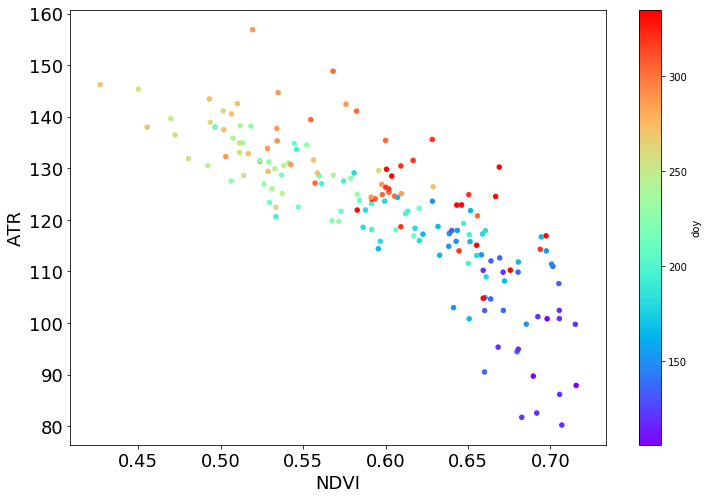

In [133]:
fig, ax = plt.subplots(figsize=(12, 8))
        
ndvi_y.plot(x='ndvi', y='ATR', c='doy', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('NDVI', fontsize=18)
plt.ylabel('ATR', fontsize=18)
plt.show()

* As shown in this figure above, there is an overall negative relationship between the Sugar processing yield (ATR) and the NDVI values
* This negative correlation has greater magnitude (a steeper slope) during earlier DOY than the rest of the year

### Daily FEWS_PET versus Sugar Content
In addition to NDVI, there are various weather condition features that may be able to capture variation in the sugar processing yield. The potential evapotranspiration is one important measurement: [FEWS_PET](https://app.gro-intelligence.com/dictionary/items/5072)

In [24]:
entities = {}
entities['item_id'] =  5072
entities['metric_id'] = 4660031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 44
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-06-14T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-14T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}


In [30]:
model.get_df()
raw_pet = model._data_frame[model._data_frame['metric_id'] == 4660031]
raw_pet.tail()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value,doy,year
4177,2019-06-09,1,2,1,5072,4660031,10408,2019-06-09T00:00:00.000Z,2,2.542767,160,2019
4178,2019-06-10,1,2,1,5072,4660031,10408,2019-06-10T00:00:00.000Z,2,2.695916,161,2019
4179,2019-06-11,1,2,1,5072,4660031,10408,2019-06-11T00:00:00.000Z,2,2.665745,162,2019
4180,2019-06-13,1,2,1,5072,4660031,10408,2019-06-13T00:00:00.000Z,2,2.592219,164,2019
4181,2019-06-14,1,2,1,5072,4660031,10408,2019-06-14T00:00:00.000Z,2,2.680362,165,2019


In [26]:
raw_pet[date_index] = pd.to_datetime(raw_pet[date_index])

raw_pet.loc[:, 'doy'] = raw_pet[date_index].dt.dayofyear
raw_pet.loc[:, 'year'] = raw_pet[date_index].dt.year


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

* Since PET is available at daily time step, we could directly aggregate it to match with the same periods of the Sugar processing yield or ATR dataset
* First merge the DOY information from the ATR dataset and then aggregate PET to those periods

In [2]:
pet_agg = raw_pet[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
pet_agg = pet_agg[pet_agg['year'] >= 2008][pet_agg['doy']>=100][pet_agg['doy']<=350]
pet_grouped = pet_agg.fillna(method='bfill').groupby(['year','DOY']).mean().reset_index()

pet_y = df_within_range.merge(pet_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')

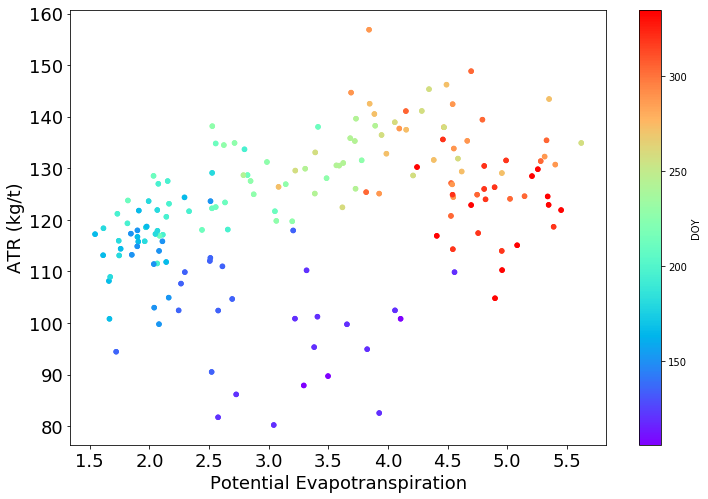

In [212]:
fig, ax = plt.subplots(figsize=(12, 8))
        
pet_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Potential Evapotranspiration', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* There appears to be a positive relationship between ATR and PET for the DOY between 170 to 260, 
* While the rest of the days of a year appeared to show a much weaker relationship

### Daily TRMM precipitation versus Sugar Content
The daily precipitation is another weather variable that might be important to the sugar processing yield.
[TRMM](https://app.gro-intelligence.com/dictionary/sources/35)
[Precipitation](https://app.gro-intelligence.com/dictionary/items/10081)

In [35]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 35
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 104642, u'region_name': u'Borac\xe9ia', u'item_name': u'Rainfall (modeled)', u'partner_regi

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109285, u'region_name': u'Adamantina', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109286, u'region_name': u'Adolfo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109286, u'region_name': u'Adolfo', u'item_name': u'Rainfall (modeled)', u'par

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109295, u'region_name': u'Altair', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109296, u'region_name': u'Altin\xf3polis', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109296, u'region_name': u'Altin\xf3polis', u'item_name': u'Rainfall (mode

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109305, u'region_name': u'Am\xe9rico de Campos', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109306, u'region_name': u'Amparo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109306, u'region_name': u'Amparo', u'item_name': u'Rainfall (modele

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109316, u'region_name': u'Ara\xe7atuba', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109316, u'region_name': u'Ara\xe7atuba', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109317, u'region_name': u'Ara\xe7oiaba da Serra', u'item_name': u'Rainfall (modeled)', u'

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109326, u'region_name': u'Arei\xf3polis', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109327, u'region_name': u'Ariranha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109327, u'region_name': u'Ariranha', u'item_name': u'Rainfall (modeled)'

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109337, u'region_name': u'Bady Bassitt', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109337, u'region_name': u'Bady Bassitt', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109338, u'region_name': u'Balbinos', u'item_name': u'Rainfall (modeled)', u'partner_regio

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109347, u'region_name': u'Barretos', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109348, u'region_name': u'Barrinha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109348, u'region_name': u'Barrinha', u'item_name': u'Rainfall (modeled)', u'p

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109358, u'region_name': u'Birigui', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109358, u'region_name': u'Birigui', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109359, u'region_name': u'Biritiba Mirim', u'item_name': u'Rainfall (modeled)', u'partner_region_na

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109368, u'region_name': u'Borebi', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109369, u'region_name': u'Botucatu', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109369, u'region_name': u'Botucatu', u'item_name': u'Rainfall (modeled)', u'par

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109379, u'region_name': u'Cabre\xfava', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109379, u'region_name': u'Cabre\xfava', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109380, u'region_name': u'Ca\xe7apava', u'item_name': u'Rainfall (modeled)', u'partner_regi

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109389, u'region_name': u'Cajuru', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109390, u'region_name': u'Campina do Monte Alegre', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109390, u'region_name': u'Campina do Monte Alegre', u'item_name'

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109399, u'region_name': u'Canitar', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109400, u'region_name': u'Cap\xe3o Bonito', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109400, u'region_name': u'Cap\xe3o Bonito', u'item_name': u'Rainfall (m

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109410, u'region_name': u'Catigua', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109410, u'region_name': u'Catigua', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109411, u'region_name': u'Cedral', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'W

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109420, u'region_name': u'Conchal', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109421, u'region_name': u'Conchas', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109421, u'region_name': u'Conchas', u'item_name': u'Rainfall (modeled)', u'part

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109431, u'region_name': u'Cruz\xe1lia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109431, u'region_name': u'Cruz\xe1lia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109432, u'region_name': u'Cruzeiro', u'item_name': u'Rainfall (modeled)', u'partner_region_

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109441, u'region_name': u'Dourado', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109442, u'region_name': u'Dracena', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109442, u'region_name': u'Dracena', u'item_name': u'Rainfall (modeled)', u'part

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109452, u'region_name': u'Embu-Gua\xe7u', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109452, u'region_name': u'Embu-Gua\xe7u', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109453, u'region_name': u'Emilian\xf3polis', u'item_name': u'Rainfall (modeled)', u'par

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109462, u'region_name': u'Fernando Prestes', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109462, u'region_name': u'Fernando Prestes', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109463, u'region_name': u'Fernand\xf3polis', u'item_name': u'Rainfall (modeled)',

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109472, u'region_name': u'Franco da Rocha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109473, u'region_name': u'Gabriel Monteiro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109473, u'region_name': u'Gabriel Monteiro', u'item_name': u'R

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109483, u'region_name': u'Gua\xedra', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109483, u'region_name': u'Gua\xedra', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109484, u'region_name': u'Guapia\xe7u', u'item_name': u'Rainfall (modeled)', u'partner_region_n

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109493, u'region_name': u'Hercul\xe2ndia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109494, u'region_name': u'Holambra', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109494, u'region_name': u'Holambra', u'item_name': u'Rainfall (modeled)

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109504, u'region_name': u'Iep\xea', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109504, u'region_name': u'Iep\xea', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109505, u'region_name': u'Igara\xe7u do Tiet\xea', u'item_name': u'Rainfall (modeled)', u'partner_r

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109514, u'region_name': u'In\xfabia Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109515, u'region_name': u'Ipaucu', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109515, u'region_name': u'Ipaucu', u'item_name': u'Rainfall (modeled)

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109525, u'region_name': u'Ita\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109525, u'region_name': u'Ita\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109526, u'region_name': u'Itajobi', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109535, u'region_name': u'Itapirapu\xe3 Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109536, u'region_name': u'It\xe1polis', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109536, u'region_name': u'It\xe1polis', u'item_name': u'Rain

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109546, u'region_name': u'Itirapu\xe3', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109546, u'region_name': u'Itirapu\xe3', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109547, u'region_name': u'Itobi', u'item_name': u'Rainfall (modeled)', u'partner_region_nam

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109556, u'region_name': u'Jaguari\xfana', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109557, u'region_name': u'Jales', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109557, u'region_name': u'Jales', u'item_name': u'Rainfall (modeled)', u'pa

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109567, u'region_name': u'J\xfalio Mesquita', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109567, u'region_name': u'J\xfalio Mesquita', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109568, u'region_name': u'Jumirim', u'item_name': u'Rainfall (modeled)', u'part

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109577, u'region_name': u'Leme', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109578, u'region_name': u'Len\xe7\xf3is Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109578, u'region_name': u'Len\xe7\xf3is Paulista', u'item_name': u'

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109588, u'region_name': u'Luisiania', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109588, u'region_name': u'Luisiania', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109589, u'region_name': u'Lupercio', u'item_name': u'Rainfall (modeled)', u'partner_region_name

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109598, u'region_name': u'Mangaratiba', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109599, u'region_name': u'Marab\xe1 Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109599, u'region_name': u'Marab\xe1 Paulista', u'item_name': u'R

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109609, u'region_name': u'Meridiano', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109609, u'region_name': u'Meridiano', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109610, u'region_name': u'Mes\xf3polis', u'item_name': u'Rainfall (modeled)', u'partner_region_

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109619, u'region_name': u'Mococa', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109619, u'region_name': u'Mococa', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109620, u'region_name': u'Mogi das Cruzes', u'item_name': u'Rainfall (modeled)', u'partner_region_nam

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109629, u'region_name': u'Monte Azul Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109630, u'region_name': u'Monte Castelo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109630, u'region_name': u'Monte Castelo', u'item_name': u'Rai

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109640, u'region_name': u'Nazar\xe9 Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109640, u'region_name': u'Nazar\xe9 Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109641, u'region_name': u'Neves Paulista', u'item_name': u'Rainfall (modeled)

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109650, u'region_name': u'Nova Guataporanga', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109651, u'region_name': u'Nova Independ\xeancia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109651, u'region_name': u'Nova Independ\xeancia', u'ite

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109661, u'region_name': u'Oriente', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109661, u'region_name': u'Oriente', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109662, u'region_name': u'Orindi\xfava', u'item_name': u'Rainfall (modeled)', u'partner_region_name

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109671, u'region_name': u'Palestina', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109672, u'region_name': u'Palmares Paulista', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109672, u'region_name': u'Palmares Paulista', u'item_name': u'Rainf

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109682, u'region_name': u'Pardinho', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109682, u'region_name': u'Pardinho', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109683, u'region_name': u'Pariquera-A\xe7u', u'item_name': u'Rainfall (modeled)', u'partner_regio

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109692, u'region_name': u'Pedran\xf3polis', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109693, u'region_name': u'Pedregulho', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109693, u'region_name': u'Pedregulho', u'item_name': u'Rainfall (mod

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109703, u'region_name': u'Pilar do Sul', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109703, u'region_name': u'Pilar do Sul', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109704, u'region_name': u'Pindamonhangaba', u'item_name': u'Rainfall (modeled)', u'partne

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109713, u'region_name': u'Pirajui', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109714, u'region_name': u'Piraju\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109714, u'region_name': u'Piraju\xed', u'item_name': u'Rainfall (modeled)', 

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109724, u'region_name': u'Pomp\xe9ia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109724, u'region_name': u'Pomp\xe9ia', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109725, u'region_name': u'Ponga\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_n

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109734, u'region_name': u'Potirendaba', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109735, u'region_name': u'Pracinha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109735, u'region_name': u'Pracinha', u'item_name': u'Rainfall (modeled)', 

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109744, u'region_name': u'Promiss\xe3o', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109745, u'region_name': u'Quadra', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109745, u'region_name': u'Quadra', u'item_name': u'Rainfall (modeled)', u'p

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109755, u'region_name': u'Registro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109755, u'region_name': u'Registro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109756, u'region_name': u'Restinga', u'item_name': u'Rainfall (modeled)', u'partner_region_name':

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109765, u'region_name': u'Ribeirao Preto', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109765, u'region_name': u'Ribeirao Preto', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109766, u'region_name': u'Rifaina', u'item_name': u'Rainfall (modeled)', u'partner_re

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109775, u'region_name': u'Roseira', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109776, u'region_name': u'Rubi\xe1cea', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109776, u'region_name': u'Rubi\xe1cea', u'item_name': u'Rainfall (modeled)'

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109786, u'region_name': u'Salto do Pirapora', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109786, u'region_name': u'Salto do Pirapora', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109787, u'region_name': u'Salto Grande', u'item_name': u'Rainfall (modeled)', u

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109796, u'region_name': u'Santa Cruz das Palmeiras', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109796, u'region_name': u'Santa Cruz das Palmeiras', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109797, u'region_name': u'Santa Cruz do Rio Pardo', u'item_name':

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109806, u'region_name': u'Santa Rita do Passa Quatro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109806, u'region_name': u'Santa Rita do Passa Quatro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109807, u'region_name': u'Santa Rosa de Viterbo', u'item_name

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109816, u'region_name': u'Santo Ant\xf4nio do Pinhal', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109816, u'region_name': u'Santo Ant\xf4nio do Pinhal', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109817, u'region_name': u'Santo Expedito', u'item_name': u'Ra

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109826, u'region_name': u'S\xe3o Jo\xe3o das Duas Ponte', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109826, u'region_name': u'S\xe3o Jo\xe3o das Duas Ponte', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109827, u'region_name': u'S\xe3o Jo\xe3o de Iracema', u

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109836, u'region_name': u'S\xe3o Luiz do Paraitinga', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109836, u'region_name': u'S\xe3o Luiz do Paraitinga', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109837, u'region_name': u'S\xe3o Manuel', u'item_name': u'Rainf

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109846, u'region_name': u'S\xe3o Vicente', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109846, u'region_name': u'S\xe3o Vicente', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109847, u'region_name': u'Sarapu\xed', u'item_name': u'Rainfall (modeled)', u'partner

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109856, u'region_name': u'Silveiras', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109857, u'region_name': u'Socorro', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109857, u'region_name': u'Socorro', u'item_name': u'Rainfall (modeled)', u'pa

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109867, u'region_name': u'Tagua\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109867, u'region_name': u'Tagua\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109868, u'region_name': u'Taia\xe7u', u'item_name': u'Rainfall (modeled)', u'partner_region_nam

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109877, u'region_name': u'Taquariva\xed', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109878, u'region_name': u'Tarabai', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109878, u'region_name': u'Tarabai', u'item_name': u'Rainfall (modeled)', 

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109888, u'region_name': u'Torrinha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109888, u'region_name': u'Torrinha', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109889, u'region_name': u'Trabiju', u'item_name': u'Rainfall (modeled)', u'partner_region_name': 

INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109898, u'region_name': u'Ubatuba', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109899, u'region_name': u'Ubirajara', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109899, u'region_name': u'Ubirajara', u'item_name': u'Rainfall (modeled)', u'

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109909, u'region_name': u'Vargem Grande do Sul', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109909, u'region_name': u'Vargem Grande do Sul', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109910, u'region_name': u'Vargem Grande Paulista', u'item_name': u'Rainfa

Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109919, u'region_name': u'Zacarias', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2019-06-15T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109919, u'region_name': u'Zacarias', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 104650, u'region_name': u'Ibirarema', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 104650, u'region_name': u'Ibirarema', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109285, u'region_name': u'Adamantina', u'item_nam

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109293, u'region_name': u'Alambari', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109294, u'region_name': u'Alfredo Marconde', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109294, u'region_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109303, u'region_name': u'Americana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109303, u'region_name': u'Americana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109304, u'region_name': u'Am\xe9rico Brasiliense'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109313, u'region_name': u'Aparecida doeste', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109313, u'region_name': u'Aparecida doeste', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109314, u'region_name': u'Apia\xed'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109323, u'region_name': u'Arco-\xedris', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109323, u'region_name': u'Arco-\xedris', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109324, u'region_name': u'Arealva', u'item_

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109333, u'region_name': u'Auriflama', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109333, u'region_name': u'Auriflama', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109334, u'region_name': u'Ava\xed', u'item_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109343, u'region_name': u'Bariri', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109343, u'region_name': u'Bariri', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109344, u'region_name': u'Barra Bonita', u'item_name': 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109353, u'region_name': u'Bebedouro', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109353, u'region_name': u'Bebedouro', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109354, u'region_name': u'Bento de Abreu', u'item

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109363, u'region_name': u'Boituva', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109363, u'region_name': u'Boituva', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109364, u'region_name': u'Bom Sucesso de Itarar\xe9',

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109373, u'region_name': u'Brodosqui', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109373, u'region_name': u'Brodosqui', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109374, u'region_name': u'Brotas', u'item_name': 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109383, u'region_name': u'Caiabu', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109383, u'region_name': u'Caiabu', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109384, u'region_name': u'Caieiras', u'item_name': u'Ra

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109393, u'region_name': u'Campos do Jord\xe3o', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109393, u'region_name': u'Campos do Jord\xe3o', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109394, u'region_name': u'Cam

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109402, u'region_name': u'Capivari', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109403, u'region_name': u'Caraguatatuba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109403, u'region_name': u'

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109412, u'region_name': u'Cerqueira C\xe9sar', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109413, u'region_name': u'Cerquilho', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109413, u'region_nam

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109422, u'region_name': u'Cordeir\xf3polis', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109423, u'region_name': u'Coroados', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109423, u'region_name':

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109432, u'region_name': u'Cruzeiro', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109433, u'region_name': u'Cubat\xe3o', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109433, u'region_name': u'Cub

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109442, u'region_name': u'Dracena', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109443, u'region_name': u'Duartina', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109443, u'region_name': u'Duarti

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109452, u'region_name': u'Embu-Gua\xe7u', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109453, u'region_name': u'Emilian\xf3polis', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109453, u'region_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109462, u'region_name': u'Fernando Prestes', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109462, u'region_name': u'Fernando Prestes', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109463, u'region_name': u'Fernand\x

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109472, u'region_name': u'Franco da Rocha', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109472, u'region_name': u'Franco da Rocha', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109473, u'region_name': u'Gabriel Mon

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109482, u'region_name': u'Guaimb\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109482, u'region_name': u'Guaimb\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109483, u'region_name': u'Gua\xedra', u'item_na

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109492, u'region_name': u'Guzolandia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109492, u'region_name': u'Guzolandia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109493, u'region_name': u'Hercul\xe2ndia', u'it

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109502, u'region_name': u'Ibi\xfana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109502, u'region_name': u'Ibi\xfana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109503, u'region_name': u'Ic\xe9m', u'item_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109512, u'region_name': u'Indiana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109512, u'region_name': u'Indiana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109513, u'region_name': u'Indiapor\xe3', u'item_name'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109522, u'region_name': u'Irapu\xe3', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109522, u'region_name': u'Irapu\xe3', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109523, u'region_name': u'Irapuru', u'item_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109532, u'region_name': u'Itapeva', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109532, u'region_name': u'Itapeva', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109533, u'region_name': u'Itapevi', u'item_name': u'R

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109542, u'region_name': u'Itariri', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109542, u'region_name': u'Itariri', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109543, u'region_name': u'Itatiba', u'item_name': u'R

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109552, u'region_name': u'Jabuticabal', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109552, u'region_name': u'Jabuticabal', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109553, u'region_name': u'Jacare\xed', u'item

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109562, u'region_name': u'Ja\xfa', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109562, u'region_name': u'Ja\xfa', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109563, u'region_name': u'Jeriquara', u'item_name': u'R

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109572, u'region_name': u'Juquitiba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109572, u'region_name': u'Juquitiba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109573, u'region_name': u'Lagoinha', u'item_name'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109582, u'region_name': u'Lorena', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109582, u'region_name': u'Lorena', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109583, u'region_name': u'Lourdes', u'item_name': u'Rai

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109592, u'region_name': u'Macaubal', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109592, u'region_name': u'Macaubal', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109593, u'region_name': u'Macedonia', u'item_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109602, u'region_name': u'Mari\xe1polis', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109602, u'region_name': u'Mari\xe1polis', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109603, u'region_name': u'Mar\xedlia', u'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109612, u'region_name': u'Mineiros do Tiet\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109612, u'region_name': u'Mineiros do Tiet\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109613, u'region_name': u'M

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109621, u'region_name': u'Mogi Gua\xe7u', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109622, u'region_name': u'Mogi Mirim', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109622, u'region_name': 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109631, u'region_name': u'Monte Mor', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109631, u'region_name': u'Monte Mor', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109632, u'region_name': u'Monteiro Lobato', u'ite

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109641, u'region_name': u'Neves Paulista', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109641, u'region_name': u'Neves Paulista', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109642, u'region_name': u'Nhandeara', u

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109650, u'region_name': u'Nova Guataporanga', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109651, u'region_name': u'Nova Independ\xeancia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109651, u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109660, u'region_name': u'Onda Verde', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109660, u'region_name': u'Onda Verde', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109661, u'region_name': u'Oriente', u'item_name

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109670, u'region_name': u'Pacaembu', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109670, u'region_name': u'Pacaembu', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109671, u'region_name': u'Palestina', u'item_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109680, u'region_name': u'Paranapu\xe3', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109680, u'region_name': u'Paranapu\xe3', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109681, u'region_name': u'Parapu\xe3', u'it

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109690, u'region_name': u'Pederneiras', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109690, u'region_name': u'Pederneiras', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109691, u'region_name': u'Pedra Bela', u'item

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109700, u'region_name': u'Peru\xedbe', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109700, u'region_name': u'Peru\xedbe', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109701, u'region_name': u'Piacatu', u'item_name

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109710, u'region_name': u'Piracaia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109710, u'region_name': u'Piracaia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109711, u'region_name': u'Piracicaba', u'item_name'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109720, u'region_name': u'Planalto', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109720, u'region_name': u'Planalto', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109721, u'region_name': u'Platina', u'item_name': u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109730, u'region_name': u'Porangaba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109730, u'region_name': u'Porangaba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109731, u'region_name': u'Porto Feliz', u'item_na

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109740, u'region_name': u'Presidente Bernardes', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109740, u'region_name': u'Presidente Bernardes', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109741, u'region_name': u'P

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109749, u'region_name': u'Quitana', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109750, u'region_name': u'Rafard', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109750, u'region_name': u'Rafard',

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109759, u'region_name': u'Ribeir\xe3o Branco', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109759, u'region_name': u'Ribeir\xe3o Branco', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109760, u'region_name': u'Ribei

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109768, u'region_name': u'Rin\xf3polis', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109769, u'region_name': u'Rio Claro', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109769, u'region_name': u'

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109778, u'region_name': u'Sabino', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109779, u'region_name': u'Sagres', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109779, u'region_name': u'Sagres', 

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109788, u'region_name': u'Sandovalina', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109789, u'region_name': u'Santa Ad\xe9lia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109789, u'region_name

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109798, u'region_name': u'Santa Ernestina', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109798, u'region_name': u'Santa Ernestina', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109799, u'region_name': u'Santa F\xe9

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109807, u'region_name': u'Santa Rosa de Viterbo', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109808, u'region_name': u'Santa Salete', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109808, u'regi

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109817, u'region_name': u'Santo Expedito', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109817, u'region_name': u'Santo Expedito', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109818, u'region_name': u'Sant\xf3polis

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109826, u'region_name': u'S\xe3o Jo\xe3o das Duas Ponte', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109827, u'region_name': u'S\xe3o Jo\xe3o de Iracema', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'regio

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109836, u'region_name': u'S\xe3o Luiz do Paraitinga', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109836, u'region_name': u'S\xe3o Luiz do Paraitinga', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109837, u'region_

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109845, u'region_name': u'S\xe3o Sim\xe3o', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109846, u'region_name': u'S\xe3o Vicente', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109846, u'region_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109855, u'region_name': u'Sever\xednia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109855, u'region_name': u'Sever\xednia', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109856, u'region_name': u'Silveiras', u'ite

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109865, u'region_name': u'Tabo\xe3o da Serra', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109865, u'region_name': u'Tabo\xe3o da Serra', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109866, u'region_name': u'Tacib

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109875, u'region_name': u'Taquaritinga', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109875, u'region_name': u'Taquaritinga', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109876, u'region_name': u'Taquarituba', u'i

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109885, u'region_name': u'Tiet\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109885, u'region_name': u'Tiet\xea', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109886, u'region_name': u'Timburi', u'item_name': u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109895, u'region_name': u'Turi\xfaba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109895, u'region_name': u'Turi\xfaba', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109896, u'region_name': u'Turmalina', u'item_na

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109905, u'region_name': u'Valentim Gentil', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109905, u'region_name': u'Valentim Gentil', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109906, u'region_name': u'Valinhos', 

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109914, u'region_name': u'Viradouro', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109915, u'region_name': u'Vista Alegre do Alto', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 109915, u'region_n

In [36]:
model.get_df()
raw_trmm = model._data_frame[(model._data_frame['metric_id'] == 2100031) & (model._data_frame['region_id']==region_id)]
raw_trmm[date_index] = pd.to_datetime(raw_trmm[date_index])

raw_trmm.loc[:, 'doy'] = raw_trmm[date_index].dt.dayofyear
raw_trmm.loc[:, 'year'] = raw_trmm[date_index].dt.year

print(raw_trmm.shape)

(7411, 10)

* Similar to PET, TRMM is also a data source at the daily timestep, so we follow a similar procedure to aggregate it to the same periods as the ATR dataset

In [40]:
trmm_agg = raw_trmm[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
trmm_agg = trmm_agg[trmm_agg['year'] >= 2008][trmm_agg['doy']>=100][trmm_agg['doy']<=350]


trmm_grouped = trmm_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

trmm_y = df_within_range.merge(trmm_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
trmm_y.head()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,ATR,DOY,Year,value,year
0,2008-04-15,23,866,1,7539,6881050,10408,2008-04-01T00:00:00.000Z,866,87.897155,106,2008,12.132686,2008
1,2008-04-30,23,866,1,7539,6881050,10408,2008-04-16T00:00:00.000Z,866,86.164431,121,2008,4.674732,2008
2,2008-05-15,23,866,1,7539,6881050,10408,2008-05-01T00:00:00.000Z,866,94.437959,136,2008,1.804685,2008
3,2008-05-31,23,866,1,7539,6881050,10408,2008-05-16T00:00:00.000Z,866,104.925017,152,2008,1.212690,2008
4,2008-06-15,23,866,1,7539,6881050,10408,2008-06-01T00:00:00.000Z,866,115.774950,167,2008,0.919376,2008


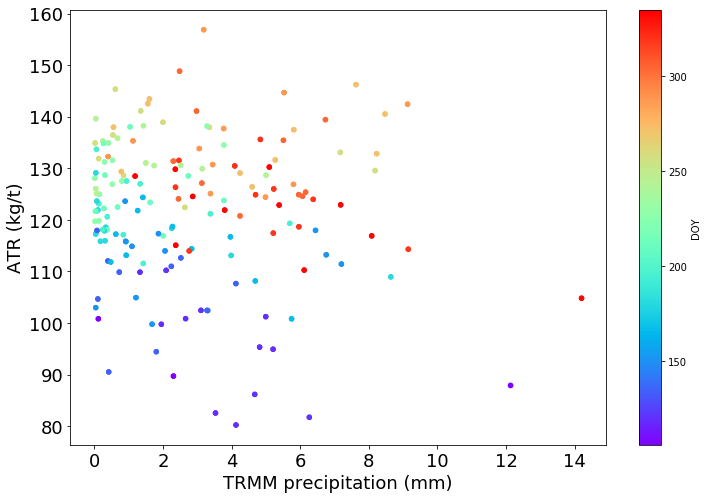

In [207]:
fig, ax = plt.subplots(figsize=(12, 8))
        
trmm_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('TRMM precipitation (mm)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* As shown in the scatter plot above, there appears to be a mild negative relationship between ATR and TRMM precipitation post the DOY 300 and prior to the DOY 200

### Daily LST temperature versus Sugar Content
The Land Surface Temperature ([LST](https://app.gro-intelligence.com/dictionary/sources/26)) is a dailiy timestep temperature data source.


In [41]:
entities = {}
entities['item_id'] =  10089
entities['metric_id'] = 2540047
entities['frequency_id'] = 1 # daily
entities['source_id'] = 26
entities['region_id'] = region_id


for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 104642, u'region_name': u'Borac\xe9ia', u'item_name': u'Land temperature (daytime, mo

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109285, u'region_name': u'Adamantina', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109285, u'region_name': u'Adamantina', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109286, u'region_name': u'Adolfo', u'item_name': u'Land temperature (daytime, modeled)'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109295, u'region_name': u'Altair', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109295, u'region_name': u'Altair', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109296, u'region_name': u'Altin\xf3polis', u'item_name': u'Land temperature (daytime, modeled)'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109305, u'region_name': u'Am\xe9rico de Campos', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109305, u'region_name': u'Am\xe9rico de Campos', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109306, u'region_name': u'Amparo', u'item_name': u'Land temperature

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109315, u'region_name': u'Ara\xe7ariguama', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109315, u'region_name': u'Ara\xe7ariguama', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109316, u'region_name': u'Ara\xe7atuba', u'item_name': u'Land temperature (da

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109325, u'region_name': u'Areias', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109325, u'region_name': u'Areias', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109326, u'region_name': u'Arei\xf3polis', u'item_name': u'Land temperature (daytime, modeled)',

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109335, u'region_name': u'Avanhandava', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109336, u'region_name': u'Avare', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109336, u'region_name': u'Avare', u'item_name': u'Land temperature (day

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109345, u'region_name': u'Barra do Chap\xe9u', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109346, u'region_name': u'Barra do Turvo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109346, u'region_name': u'Barra do Turvo', u'item_name'

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109355, u'region_name': u'Bernardino de Campos', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109356, u'region_name': u'Bertioga', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109356, u'region_name': u'Bertioga', u'item_name': u'Land t

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109365, u'region_name': u'Bon Jesus dos Perdoes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109366, u'region_name': u'Bor\xe1', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109366, u'region_name': u'Bor\xe1', u'item_name': u'Land te

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109376, u'region_name': u'Buritama', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109376, u'region_name': u'Buritama', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109377, u'region_name': u'Buritizal', u'item_name': u'Land temperature (daytime, modeled)',

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109386, u'region_name': u'Cajamar', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109386, u'region_name': u'Cajamar', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109387, u'region_name': u'Cajati', u'item_name': u'Land temperature (daytime, modeled)', u'pa

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109396, u'region_name': u'Canas', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109396, u'region_name': u'Canas', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109397, u'region_name': u'C\xe2ndido Mota', u'item_name': u'Land temperature (daytime, modeled)',

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109406, u'region_name': u'Casa Branca', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109406, u'region_name': u'Casa Branca', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109407, u'region_name': u'C\xe1ssia dos Coqueiros', u'item_name': u'Land temperature 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109416, u'region_name': u'Chavantes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109416, u'region_name': u'Chavantes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109417, u'region_name': u'Clementina', u'item_name': u'Land temperature (daytime, modeled

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109426, u'region_name': u'Cosm\xf3polis', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109426, u'region_name': u'Cosm\xf3polis', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109427, u'region_name': u'Cosmorama', u'item_name': u'Land temperature (daytime, 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109436, u'region_name': u'Diadema', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109436, u'region_name': u'Diadema', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109437, u'region_name': u'Dirce Reis', u'item_name': u'Land temperature (daytime, modeled)', 

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109446, u'region_name': u'Echapor\xe3', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109447, u'region_name': u'Eldorado', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109447, u'region_name': u'Eldorado', u'item_name': u'Land temperatur

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109456, u'region_name': u'Esp\xedrito Santo do Turvo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109457, u'region_name': u'Estiva Gerbi', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109457, u'region_name': u'Estiva Gerbi', u'item_n

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109466, u'region_name': u'Flora Rica', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109467, u'region_name': u'Floreal', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109467, u'region_name': u'Floreal', u'item_name': u'Land temperature (

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109476, u'region_name': u'Gast\xe3o Vidigal', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109477, u'region_name': u'Gavi\xe3o Peixoto', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109477, u'region_name': u'Gavi\xe3o Peixoto', u'item_

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109486, u'region_name': u'Guar\xe1', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109487, u'region_name': u'Guare\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109487, u'region_name': u'Guare\xed', u'item_name': u'Land temperature

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109496, u'region_name': u'Iacanga', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109497, u'region_name': u'Iacri', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109497, u'region_name': u'Iacri', u'item_name': u'Land temperature (daytime

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109507, u'region_name': u'Igarat\xe1', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109507, u'region_name': u'Igarat\xe1', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109508, u'region_name': u'Iguape', u'item_name': u'Land temperature (daytime, modeled)'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109517, u'region_name': u'Ipe\xfana', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109517, u'region_name': u'Ipe\xfana', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109518, u'region_name': u'Ipigu\xe1', u'item_name': u'Land temperature (daytime, modeled)

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109527, u'region_name': u'Itaju', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109528, u'region_name': u'Itanha\xe9m', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109528, u'region_name': u'Itanha\xe9m', u'item_name': u'Land temperatur

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109537, u'region_name': u'Itaporanga', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109538, u'region_name': u'Itapu\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109538, u'region_name': u'Itapu\xed', u'item_name': u'Land temperatu

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109548, u'region_name': u'Itu', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109548, u'region_name': u'Itu', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109549, u'region_name': u'Itupeva', u'item_name': u'Land temperature (daytime, modeled)', u'partner_r

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109558, u'region_name': u'Jambeiro', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109559, u'region_name': u'Jandira', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109559, u'region_name': u'Jandira', u'item_name': u'Land temperature (da

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109568, u'region_name': u'Jumirim', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109569, u'region_name': u'Jundia\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109569, u'region_name': u'Jundia\xed', u'item_name': u'Land temperatur

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109578, u'region_name': u'Len\xe7\xf3is Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109579, u'region_name': u'Limeira', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109579, u'region_name': u'Limeira', u'item_name': u'Land t

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109588, u'region_name': u'Luisiania', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109589, u'region_name': u'Lupercio', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109589, u'region_name': u'Lupercio', u'item_name': u'Land temperature 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109599, u'region_name': u'Marab\xe1 Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109599, u'region_name': u'Marab\xe1 Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109600, u'region_name': u'Maraca\xed', u'item_name': u'Land temperature

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109609, u'region_name': u'Meridiano', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109609, u'region_name': u'Meridiano', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109610, u'region_name': u'Mes\xf3polis', u'item_name': u'Land temperature (daytime, model

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109619, u'region_name': u'Mococa', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109619, u'region_name': u'Mococa', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109620, u'region_name': u'Mogi das Cruzes', u'item_name': u'Land temperature (daytime, modeled)

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109629, u'region_name': u'Monte Azul Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109629, u'region_name': u'Monte Azul Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109630, u'region_name': u'Monte Castelo', u'item_name': u'Land temper

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109639, u'region_name': u'Natividade da Serra', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109639, u'region_name': u'Natividade da Serra', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109640, u'region_name': u'Nazar\xe9 Paulista', u'item_name': u'Land t

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109649, u'region_name': u'Nova Granada', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109649, u'region_name': u'Nova Granada', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109650, u'region_name': u'Nova Guataporanga', u'item_name': u'Land temperature (day

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109659, u'region_name': u'Ol\xedmpia', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109659, u'region_name': u'Ol\xedmpia', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109660, u'region_name': u'Onda Verde', u'item_name': u'Land temperature (daytime, model

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109669, u'region_name': u'Ouroeste', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109669, u'region_name': u'Ouroeste', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109670, u'region_name': u'Pacaembu', u'item_name': u'Land temperature (daytime, modeled)', 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109679, u'region_name': u'Paranaparema', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109679, u'region_name': u'Paranaparema', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109680, u'region_name': u'Paranapu\xe3', u'item_name': u'Land temperature (daytime,

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109689, u'region_name': u'Paulo de Faria', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109689, u'region_name': u'Paulo de Faria', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109690, u'region_name': u'Pederneiras', u'item_name': u'Land temperature (dayti

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109699, u'region_name': u'Pereiras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109699, u'region_name': u'Pereiras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109700, u'region_name': u'Peru\xedbe', u'item_name': u'Land temperature (daytime, modeled)'

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109709, u'region_name': u'Piquete', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109710, u'region_name': u'Piracaia', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109710, u'region_name': u'Piracaia', u'item_name': u'Land temperature (d

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109719, u'region_name': u'Pitangueiras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109720, u'region_name': u'Planalto', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109720, u'region_name': u'Planalto', u'item_name': u'Land temperatu

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109730, u'region_name': u'Porangaba', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109730, u'region_name': u'Porangaba', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109731, u'region_name': u'Porto Feliz', u'item_name': u'Land temperature (daytime, modele

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109740, u'region_name': u'Presidente Bernardes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109740, u'region_name': u'Presidente Bernardes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109741, u'region_name': u'Presidente Epit\xe1cio', u'item_name': u'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109750, u'region_name': u'Rafard', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109750, u'region_name': u'Rafard', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109751, u'region_name': u'Rancharia', u'item_name': u'Land temperature (daytime, modeled)', u'p

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109760, u'region_name': u'Ribeir\xe3o Corrente', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109760, u'region_name': u'Ribeir\xe3o Corrente', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109761, u'region_name': u'Ribeir\xe3o do Sul', u'item_name': u'Land

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109770, u'region_name': u'Rio das Pedras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109770, u'region_name': u'Rio das Pedras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109771, u'region_name': u'Rio Grande da Serra', u'item_name': u'Land temperatur

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109780, u'region_name': u'Sales', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109780, u'region_name': u'Sales', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109781, u'region_name': u'Sales Oliveira', u'item_name': u'Land temperature (daytime, modeled)', 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109790, u'region_name': u'Santa Albertina', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109790, u'region_name': u'Santa Albertina', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109791, u'region_name': u"Santa B\xe1rbara d'Oeste", u'item_name': u'Land tem

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109800, u'region_name': u'Santa Gertrudes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109800, u'region_name': u'Santa Gertrudes', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109801, u'region_name': u'Santa Isabel', u'item_name': u'Land temperature (da

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109810, u'region_name': u'Santana de Parna\xedba', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109810, u'region_name': u'Santana de Parna\xedba', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109811, u'region_name': u'Santo Anast\xe1cio', u'item_name': u'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109820, u'region_name': u'S\xe3o Bento do Sapuca\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109820, u'region_name': u'S\xe3o Bento do Sapuca\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109821, u'region_name': u'S\xe3o Bernardo do Campo', u'

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109830, u'region_name': u'S\xe3o Jos\xe9 da Bela Vista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109830, u'region_name': u'S\xe3o Jos\xe9 da Bela Vista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109831, u'region_name': u'S\xe3o Jos\xe9 do Barreir

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109840, u'region_name': u'S\xe3o Pedro', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109840, u'region_name': u'S\xe3o Pedro', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109841, u'region_name': u'S\xe3o Pedro do Turvo', u'item_name': u'Land temperature 

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109850, u'region_name': u'Serra Azul', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109850, u'region_name': u'Serra Azul', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109851, u'region_name': u'Serra Negra', u'item_name': u'Land temperature (daytime, mode

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109860, u'region_name': u'Sumar\xe9', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109860, u'region_name': u'Sumar\xe9', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109861, u'region_name': u'Suzan\xe1polis', u'item_name': u'Land temperature (daytime, mod

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109870, u'region_name': u'Tamba\xfa', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109870, u'region_name': u'Tamba\xfa', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109871, u'region_name': u'Tanabi', u'item_name': u'Land temperature (daytime, modeled)', 

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109880, u'region_name': u'Tatu\xed', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109881, u'region_name': u'Taubat\xe9', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109881, u'region_name': u'Taubat\xe9', u'item_name': u'Land temperatu

Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109891, u'region_name': u'Tr\xeas Fronteiras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109891, u'region_name': u'Tr\xeas Fronteiras', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109892, u'region_name': u'Tuiuti', u'item_name': u'Land temperature (da

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109901, u'region_name': u'Uni\xe3o Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109902, u'region_name': u'Ur\xe2nia', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109902, u'region_name': u'Ur\xe2nia', u'item_name': u'Land te

INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109911, u'region_name': u'V\xe1rzea Paulista', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109912, u'region_name': u'Vera Cruz', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-06-10T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109912, u'region_name': u'Vera Cruz', u'item_name': u'Land t

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 104642, u'region_name': u'Borac\xe9ia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 104643, u'region_name': u'Guara\xe7a\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 104643, u'region

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109286, u'region_name': u'Adolfo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109286, u'region_name': u'Adolfo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109287, u'region_name': u'Aguai', u'item_name': u

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109295, u'region_name': u'Altair', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109296, u'region_name': u'Altin\xf3polis', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109296, u'region_name

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109305, u'region_name': u'Am\xe9rico de Campos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109305, u'region_name': u'Am\xe9rico de Campos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109306, u'region_name

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109314, u'region_name': u'Apia\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109315, u'region_name': u'Ara\xe7ariguama', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109315, u'region_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109324, u'region_name': u'Arealva', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109324, u'region_name': u'Arealva', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109325, u'region_name': u'Areias', u'item_name'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109334, u'region_name': u'Ava\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109334, u'region_name': u'Ava\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109335, u'region_name': u'Avanhandava', u'item_

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109343, u'region_name': u'Bariri', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109344, u'region_name': u'Barra Bonita', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109344, u'region_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109353, u'region_name': u'Bebedouro', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109353, u'region_name': u'Bebedouro', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109354, u'region_name': u'Bento de Abreu', 

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109362, u'region_name': u'Bofete', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109363, u'region_name': u'Boituva', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109363, u'region_name': u'Bo

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109372, u'region_name': u'Brejo Alegre', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109372, u'region_name': u'Brejo Alegre', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109373, u'region_name': u'Brodosqui',

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109381, u'region_name': u'Cachoeira Paulista', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109382, u'region_name': u'Cafel\xe2ndia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109382, u'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109391, u'region_name': u'Campinas', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109391, u'region_name': u'Campinas', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109392, u'region_name': u'Campo Limpo Paulist

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109400, u'region_name': u'Cap\xe3o Bonito', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109401, u'region_name': u'Capela do Alto', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109401, u're

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109410, u'region_name': u'Catigua', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109410, u'region_name': u'Catigua', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109411, u'region_name': u'Cedral', u'item_name'

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109419, u'region_name': u'Col\xf4mbia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109420, u'region_name': u'Conchal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109420, u'region_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109429, u'region_name': u'Cravinhos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109429, u'region_name': u'Cravinhos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109430, u'region_name': u'Cristais Paulista

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109438, u'region_name': u'Divinol\xe2ndia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109439, u'region_name': u'Dobrada', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109439, u'region_na

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109448, u'region_name': u'Elias Fausto', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109448, u'region_name': u'Elias Fausto', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109449, u'region_name': u'Elisi\xe1ri

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109457, u'region_name': u'Estiva Gerbi', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109458, u'region_name': u'Estrela do Norte', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109458, u'reg

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109467, u'region_name': u'Floreal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109467, u'region_name': u'Floreal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109468, u'region_name': u'Fl\xf3rida Paulista',

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109476, u'region_name': u'Gast\xe3o Vidigal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109477, u'region_name': u'Gavi\xe3o Peixoto', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109477,

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109486, u'region_name': u'Guar\xe1', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109486, u'region_name': u'Guar\xe1', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109487, u'region_name': u'Guare\xed', u'item_

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109495, u'region_name': u'Hortol\xe2ndia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109496, u'region_name': u'Iacanga', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109496, u'region_nam

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109505, u'region_name': u'Igara\xe7u do Tiet\xea', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109506, u'region_name': u'Igarapava', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109506, u'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109515, u'region_name': u'Ipaucu', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109515, u'region_name': u'Ipaucu', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109516, u'region_name': u'Iper\xf3', u'item_name'

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109524, u'region_name': u'Itaber\xe1', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109525, u'region_name': u'Ita\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109525, u'region_name': 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109534, u'region_name': u'Itapira', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109534, u'region_name': u'Itapira', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109535, u'region_name': u'Itapirapu\xe3 Paulist

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109543, u'region_name': u'Itatiba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109544, u'region_name': u'Itatinga', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109544, u'region_name': u'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109553, u'region_name': u'Jacare\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109553, u'region_name': u'Jacare\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109554, u'region_name': u'Jaci', u'item_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109563, u'region_name': u'Jeriquara', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109563, u'region_name': u'Jeriquara', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109564, u'region_name': u'Joan\xf3polis', u

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109572, u'region_name': u'Juquitiba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109573, u'region_name': u'Lagoinha', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109573, u'region_name': 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109582, u'region_name': u'Lorena', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109582, u'region_name': u'Lorena', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109583, u'region_name': u'Lourdes', u'item_name':

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109591, u'region_name': u'Macatuba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109592, u'region_name': u'Macaubal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109592, u'region_name': u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109601, u'region_name': u'Marapoama', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109601, u'region_name': u'Marapoama', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109602, u'region_name': u'Mari\xe1polis', u

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109610, u'region_name': u'Mes\xf3polis', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109611, u'region_name': u'Miguel\xf3polis', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109611, u'regi

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109620, u'region_name': u'Mogi das Cruzes', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109620, u'region_name': u'Mogi das Cruzes', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109621, u'region_name': u'Mogi 

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109629, u'region_name': u'Monte Azul Paulista', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109630, u'region_name': u'Monte Castelo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109630, u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109639, u'region_name': u'Natividade da Serra', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109639, u'region_name': u'Natividade da Serra', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109640, u'region_name':

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109648, u'region_name': u'Nova Europa', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109649, u'region_name': u'Nova Granada', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109649, u'region_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109658, u'region_name': u'\xd3leo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109658, u'region_name': u'\xd3leo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109659, u'region_name': u'Ol\xedmpia', u'item_n

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109667, u'region_name': u'Ourinhos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109668, u'region_name': u'Ouro Verde', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109668, u'region_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109677, u'region_name': u'Paraibuna', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109677, u'region_name': u'Paraibuna', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109678, u'region_name': u'Para\xedso', u'it

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109686, u'region_name': u'Paulic\xe9ia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109687, u'region_name': u'Paul\xednia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109687, u'region_n

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109696, u'region_name': u'Pedro de Toledo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109696, u'region_name': u'Pedro de Toledo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109697, u'region_name': u'Pen\x

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109705, u'region_name': u'Pindorama', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109706, u'region_name': u'Pinhal', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109706, u'region_name': u'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109715, u'region_name': u'Pirangi', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109715, u'region_name': u'Pirangi', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109716, u'region_name': u'Pirapora do Bom Jesus

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109724, u'region_name': u'Pomp\xe9ia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109725, u'region_name': u'Ponga\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109725, u'region_name'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109734, u'region_name': u'Potirendaba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109734, u'region_name': u'Potirendaba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109735, u'region_name': u'Pracinha', u'

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109743, u'region_name': u'Presidente Venceslau', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109744, u'region_name': u'Promiss\xe3o', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109744, u

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109753, u'region_name': u'Regente Feij\xf3', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109753, u'region_name': u'Regente Feij\xf3', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109754, u'region_name': u'Reg

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109762, u'region_name': u'Ribeir\xe3o dos \xedndios', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109763, u'region_name': u'Ribeir\xe3o Grande', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id'

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109772, u'region_name': u'Riol\xe2ndia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109772, u'region_name': u'Riol\xe2ndia', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109773, u'region_name': u'Riversul', 

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109782, u'region_name': u'Sales\xf3polis', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109782, u'region_name': u'Sales\xf3polis', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109783, u'region_name': u'Salmour

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109791, u'region_name': u"Santa B\xe1rbara d'Oeste", u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109792, u'region_name': u'Santa Branca', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10979

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109801, u'region_name': u'Santa Isabel', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109801, u'region_name': u'Santa Isabel', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109802, u'region_name': u'Santa Lucia

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109810, u'region_name': u'Santana de Parna\xedba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109811, u'region_name': u'Santo Anast\xe1cio', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 1

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109820, u'region_name': u'S\xe3o Bento do Sapuca\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109820, u'region_name': u'S\xe3o Bento do Sapuca\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109821, u

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109829, u'region_name': u'S\xe3o Joaquim da Barra', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109830, u'region_name': u'S\xe3o Jos\xe9 da Bela Vista', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u're

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109839, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109839, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109840, u'region_name': u'S\xe3o Pedr

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109848, u'region_name': u'Sarutai\xe1', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109849, u'region_name': u'Sebastian\xf3polis do Sul', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10984

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109858, u'region_name': u'Sorocaba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109858, u'region_name': u'Sorocaba', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109859, u'region_name': u'Sud Mennucci', u'it

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109867, u'region_name': u'Tagua\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109868, u'region_name': u'Taia\xe7u', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109868, u'region_name':

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109877, u'region_name': u'Taquariva\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109877, u'region_name': u'Taquariva\xed', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109878, u'region_name': u'Tarabai',

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109886, u'region_name': u'Timburi', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109887, u'region_name': u'Torre de Pedra', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109887, u'region_nam

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109896, u'region_name': u'Turmalina', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109896, u'region_name': u'Turmalina', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109897, u'region_name': u'Ubarana', u'item_

Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109906, u'region_name': u'Valinhos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109906, u'region_name': u'Valinhos', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109907, u'region_name': u'Valpara\xedso', u'i

INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109915, u'region_name': u'Vista Alegre do Alto', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 109916, u'region_name': u'Vit\xf3ria Brasil', u'item_name': u'Land temperature (daytime, modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3460, u'metric_name': u'Temperature', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 1099

* Again, we aggregate the LST temperature data to the same periods as the ATR sugar processing yield data

In [42]:
model.get_df()
raw_lst = model._data_frame[(model._data_frame['metric_id'] == 2540047) & (model._data_frame['region_id']==region_id)]
raw_lst[date_index] = pd.to_datetime(raw_lst[date_index])

raw_lst.loc[:, 'doy'] = raw_lst[date_index].dt.dayofyear
raw_lst.loc[:, 'year'] = raw_lst[date_index].dt.year

lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
lst_agg = lst_agg[lst_agg['year'] >= 2008][lst_agg['doy']>=100][lst_agg['doy']<=350]
lst_grouped = lst_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()
print(lst_grouped.head(10))

lst_y = df_within_range.merge(lst_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
lst_y.tail()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     DOY  year      value         doy
0  106.0  2008  25.309613  103.000000
1  106.0  2011  28.299461  342.500000
2  106.0  2012  26.574739  103.000000
3  106.0  2015  26.252472  342.500000
4  106.0  2016  30.300360  103.000000
5  120.0  2008  30.340395  343.000000
6  120.0  2009  25.293926  209.514286
7  120.0  2010  26.270115  213.416667
8  120.0  2011  26.287248  110.000000
9  120.0  2012  27.930572  342.500000


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,ATR,DOY,Year,value,year
166,2018-11-15,23,866,1,7539,6881050,10408,2018-11-01T00:00:00.000Z,866,113.978723,319,2018,28.903919,2018
167,2018-11-30,23,866,1,7539,6881050,10408,2018-11-16T00:00:00.000Z,866,110.259265,334,2018,28.263827,2018
168,2019-04-30,23,866,1,7539,6881050,10408,2019-04-16T00:00:00.000Z,866,99.754063,120,2019,26.939613,2019
169,2019-05-15,23,866,1,7539,6881050,10408,2019-05-01T00:00:00.000Z,866,108.653547,135,2019,25.375579,2019
170,2019-05-31,23,866,1,7539,6881050,10408,2019-05-16T00:00:00.000Z,866,114.160160,151,2019,24.552704,2019


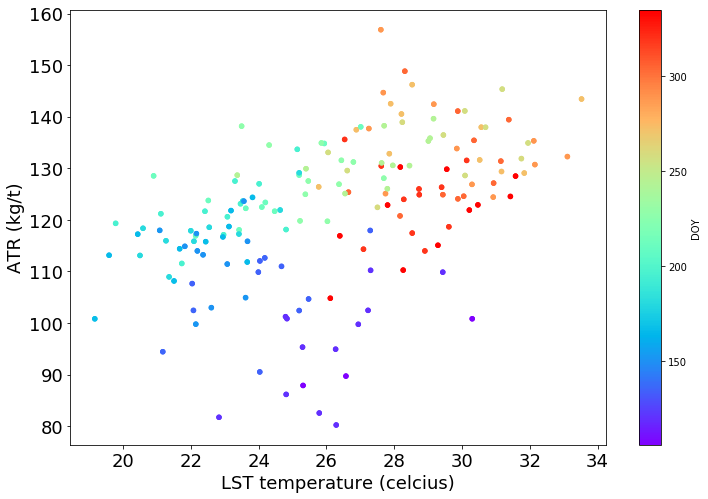

In [217]:
fig, ax = plt.subplots(figsize=(12, 8))
        
lst_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('LST temperature (celcius)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* The LST appears to be positively correlated with the ATR, especially for the DOY between 170 and 270

### Merge together the varaibles and assess relationships among them

In [ ]:
pet_y.rename(columns={'value': 'pet'}, inplace=True)
trmm_y.rename(columns={'value': 'trmm'}, inplace=True)
lst_y.rename(columns={'value': 'lst'}, inplace=True)
df_tog=ndvi_df.merge(pet_y[['pet', 'DOY','year', 'ATR']], left_on=['doy', 'year'],right_on=['DOY', 'year'], how='left'
                    ).merge(trmm_y[['trmm', 'DOY','year']], on=['DOY', 'year'], how='left'
                    ).merge(lst_y[['lst', 'DOY','year']], on=['DOY', 'year'], how='left'
                    )

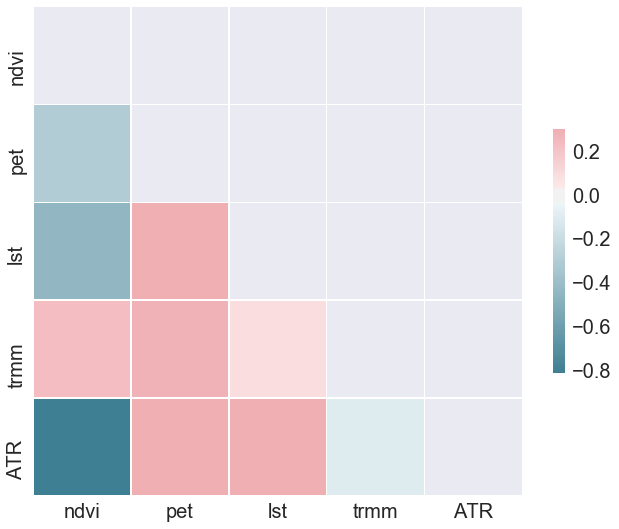

In [227]:
import seaborn as sns
corr = df_tog[['ndvi','pet','lst', 'trmm','ATR']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2) 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Intuitively, NDVI is positively correlated with precipitation and negatively correlated with LST and PET.
* Also, PET, as a modeled product with temperature and precipitation as major inputs, is positively correlated with LST and TRMM.
* Temperature appears to be mildly positively correlated with precipitation, which is because the dry season corresponds to the winter or colder season in the southern atmosphere, or Sao Paulo here.

### Cluster the points to find a refined cutting point of the Day of Year of periods
* The previous scatter plots between ATR and weather variables manifested three clusters of DOY periods
* Because of such differing responses of ATR to weather conditions at different time of the year, it would be more accurately to model those three periods separately
* First of all, we need to clearly define the boundaries of those three clusters, and KMeans is a simple clustering method to do so

In [4]:
from sklearn.cluster import KMeans
X = np.array(df_tog[['ndvi','pet','lst', 'trmm','ATR','DOY']].dropna())
f_names = ['ndvi','pet','lst', 'trmm','ATR','DOY']
kmeans = KMeans(3)
kmeans.fit(X)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

* Add a variable name `group` to record the KMeans clustering result, as printed below

In [249]:
data_decision = pd.DataFrame(X)
data_decision.columns = f_names
data_decision['group'] = y_km
data_decision.head()

,ndvi,pet,lst,trmm,ATR,DOY,group
0,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
1,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
2,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
3,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
4,0.71558,3.29436,25.3096,12.1327,87.8972,106,0


In [250]:
print(data_decision.groupby('group').min())
data_decision.groupby('group').max()

           ndvi       pet        lst      trmm         ATR  DOY
group                                                          
0      0.580872  1.544240  19.164008  0.039923   80.231441  106
1      0.426879  3.082981  25.771094  0.399399  104.807083  273
2      0.450034  1.731405  19.779119  0.012298  111.547468  196


,ndvi,pet,lst,trmm,ATR,DOY
group,,,,,,
0,0.715580,4.558520,30.300360,12.132686,129.110569,182
1,0.697306,5.452482,33.526674,14.202166,156.861358,335
2,0.650728,5.621423,31.948077,8.184012,145.340109,259


We see that the three clusters of periods are the following
* period DOY 100-182
* period DOY 196-259
* period DOY 273-350

Cutoff DOY between periods: 190, 265.
Next, we visualize the relationship between all combinations of variables colored by the clustering groups

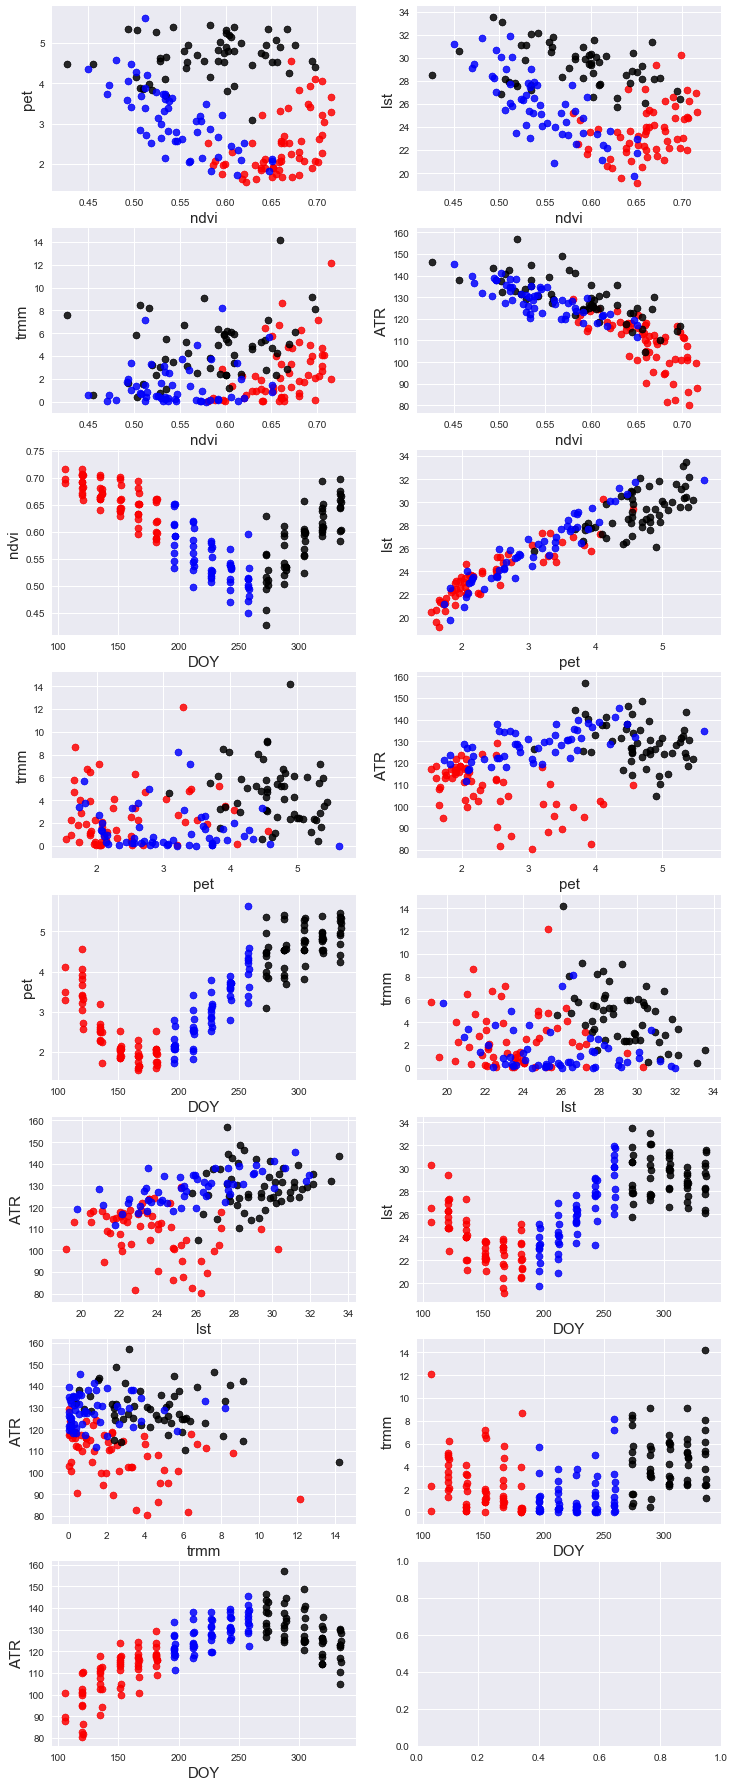

In [254]:
combos = [l for l in itertools.combinations(f_names,2)]

n_vars = len(combos)
n_rows = n_vars//2 + n_vars%2
sns.set(font_scale=1) 
alpha = 0.2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows*4))
for i in range(n_vars):
    ax = axes[i//2, i % 2]
    var_1, var2 = combos[i]
    if 'DOY' in combos[i]:
        var_1 = 'DOY'
        var2 = (set(combos[i]) - {'DOY'}).pop()
    ax.scatter(X[y_km ==0,f_names.index(var_1)], X[y_km == 0,f_names.index(var2)], s=50, c='red', alpha = alpha)
    ax.scatter(X[y_km ==1,f_names.index(var_1)], X[y_km == 1,f_names.index(var2)], s=50, c='black', alpha = alpha)
    ax.scatter(X[y_km ==2,f_names.index(var_1)], X[y_km == 2,f_names.index(var2)], s=50, c='blue', alpha = alpha)
    ax.set_xlabel(var_1, fontsize=15)
    ax.set_ylabel(var2, fontsize=15)

* The red color is the earliest group, the blue color shows the middle group and the black color represents the latest group above.
* The seansonality is also clearly portrayed by the Temperature, precipitation and PET from the DOY 100 to 350

### Fit a multivariate linear regression for each Sub-harvesting-season

In [337]:
from sklearn import linear_model
import statsmodels.api as sm

df = data_decision.copy().drop('DOY', axis=1)

for name in df.columns.values:
    df[name] = df[name].astype(float)

In [275]:
for g in df['group'].unique():
    sub_dat = df[df['group'] == g].drop('group', axis=1)
    sub_dat['intercept'] = 1.
    X = sub_dat.drop('ATR', axis=1)
    Y = sub_dat['ATR']
    # with statsmodels
    sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 

    print_model = model.summary()
    print(data_decision[data_decision['group']==g]['DOY'].dropna().max())
    print(print_model)

182
                            OLS Regression Results                            
Dep. Variable:                    ATR   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     149.4
Date:                Wed, 15 May 2019   Prob (F-statistic):           3.76e-82
Time:                        15:28:52   Log-Likelihood:                -1624.9
No. Observations:                 472   AIC:                             3260.
Df Residuals:                     467   BIC:                             3281.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ndvi        -146.6309     13.144    -11.155     

* The middle period linear regression model (DOY 196-259) appeared to have the best performance in terms of the variance explained
* The following scatter plot shows the predicted versus actual yield along the 1-1 line

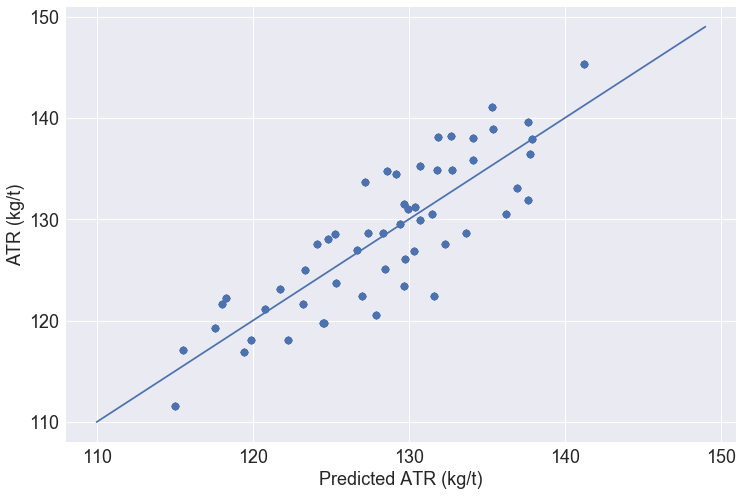

In [350]:
sub_dat = df[df['group'] == 2].drop('group', axis=1)
sub_dat['intercept'] = 1.
X = sub_dat.drop('ATR', axis=1)
Y = sub_dat['ATR']
# with statsmodels
sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
sub_dat['pred'] = predictions
sns.set(font_scale=2.5) 
fig, ax = plt.subplots(figsize=(12,8))
sub_dat.plot(x='pred', y='ATR', fontsize=18, kind='scatter', legend=False, ax=ax, s=50)
ax.plot(range(110,150), range(110,150))
plt.xlabel('Predicted ATR (kg/t)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()

In [412]:
new_dat_list = []
ranges = [(100, 190), (190, 265), (265,350)]
for l, r in ranges:
    sub_dat = df_plot[df_plot['DOY'] > l][df_plot['DOY'] < r]
    sub_dat['intercept'] = 1.
    X = sub_dat[['lst','pet','trmm','ndvi','intercept']]
    Y = sub_dat['ATR']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    lm = linear_model.LinearRegression()
    scores = cross_val_score(lm, X, Y, scoring='r2', cv=5)
    
    print('mean R-squared: {}'.format(np.mean(scores)))
    scores = cross_val_score(lm, X, Y, scoring='explained_variance', cv=5)
    print('mean Explained Variance: {}'.format(np.mean(scores)))
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()


mean R-squared: 0.115104358354
mean Explained Variance: 0.648053708702
mean R-squared: 0.484554827472
mean Explained Variance: 0.646851267354
mean R-squared: 0.321148593303


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


mean Explained Variance: 0.39222095567


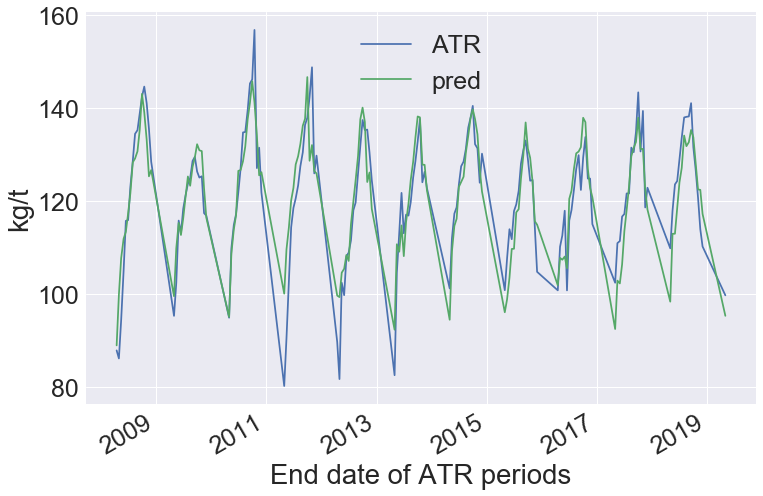

In [375]:
with_pred.set_index('end_date')

fig, ax = plt.subplots(figsize=(12,8))
with_pred.plot(x='end_date', y='ATR', ax=ax)
with_pred.plot(x='end_date', y='pred', ax=ax)
plt.xlabel('End date of ATR periods')
plt.ylabel('kg/t')
plt.show()

* Our model estimated ATR of all periods combined matched well with the Actual, especially during the peak ATR value periods